In [171]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from mle_toolbox import load_result_logs
from mle_toolbox.visualize import visualize_2D_grid
from visualize import imp_plot
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## IMP Across Brax Environments + Baselines

In [184]:
meta_log, hyper_log = load_result_logs("../experiments/fmnist_snes_128")
hyper_log["imp_config/baseline_name"].unique()

/Users/rob/anaconda3/envs/mle-toolbox/lib/python3.9/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


array(['final-ticket', 'random-reinit', 'sig2noise'], dtype=object)

In [185]:
def get_perf_env(meta_log, hyper_log, metric="final_perf", get_random=True):
    """Filter dataframe for environment and popsize."""
    run_id_ticket = hyper_log.filter({"imp_config/baseline_name": "final-ticket"}).run_id.iloc[0]
    run_id_sig2noi = hyper_log.filter({"imp_config/baseline_name": "sig2noise"}).run_id.iloc[0]
    ticket_perf = meta_log[run_id_ticket].stats[metric]
    sig2noise_perf = meta_log[run_id_sig2noi].stats[metric]
    results = (sig2noise_perf.mean[:20] - ticket_perf.mean[:20])/sig2noise_perf.mean[0]
    return results

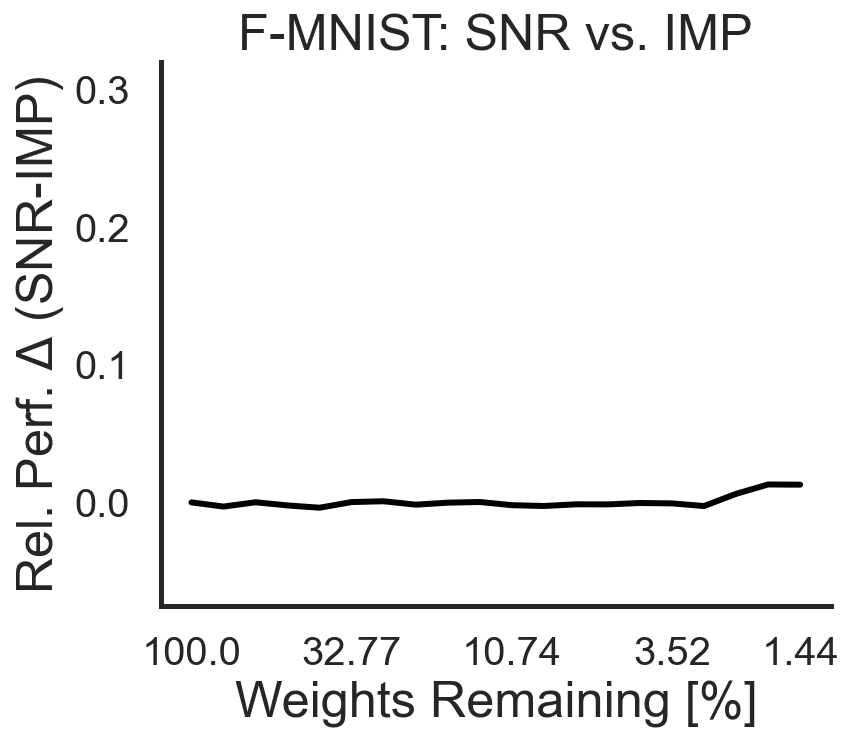

In [187]:
results = get_perf_env(meta_log, hyper_log)
def sparse(iteration, sparsity=0.8):
    return (sparsity ** iteration) * 100.0

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(results, color="black")
ax.set_xlabel("Weights Remaining [%]")
ax.set_ylabel(r"Rel. Perf. $\Delta$ (SNR-IMP)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
num_iters = results.shape[0]
xtick_labels = [
        round(sparse(i, 1 - 0.2), 2)
        for i in np.arange(0, num_iters, 5)
]
xtick_labels.append(round(sparse(num_iters - 1, 1 - 0.2), 2))
xticks = np.arange(0, num_iters, 5).tolist()
xticks.append(num_iters - 1)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set_ylim(-0.075, 0.32)
ax.set_title("F-MNIST: SNR vs. IMP")
ax.tick_params(axis="both", which="major", labelsize=20)

In [188]:
def get_perf_env(meta_log, hyper_log, metric="final_perf", get_random=True):
    """Filter dataframe for environment and popsize."""
    run_id_ticket = hyper_log.filter({"imp_config/baseline_name": "final-ticket"}).run_id.iloc[0]
    run_id_sig2noi = hyper_log.filter({"imp_config/baseline_name": "sig2noise"}).run_id.iloc[0]
    ticket_perf = meta_log[run_id_ticket].stats[metric]
    sig2noise_perf = meta_log[run_id_sig2noi].stats[metric]
    results = {"IMP": ticket_perf, "SNR": sig2noise_perf}
    if get_random:
        run_id_random = hyper_log.filter({"imp_config/baseline_name": "random-reinit"}).run_id.iloc[0]
        random_perf = meta_log[run_id_random].stats[metric]
        results["random"] = random_perf
    return results

# Pruning Threshold over Iterations

[100.0, 32.77, 10.74, 3.52, 1.44]


(<Figure size 432x360 with 1 Axes>,
 <AxesSubplot:title={'center':'F-MNIST: Pruning Threshold'}, xlabel='Weights Remaining [%]', ylabel='Threshold: $\\rho(s_t)$'>)

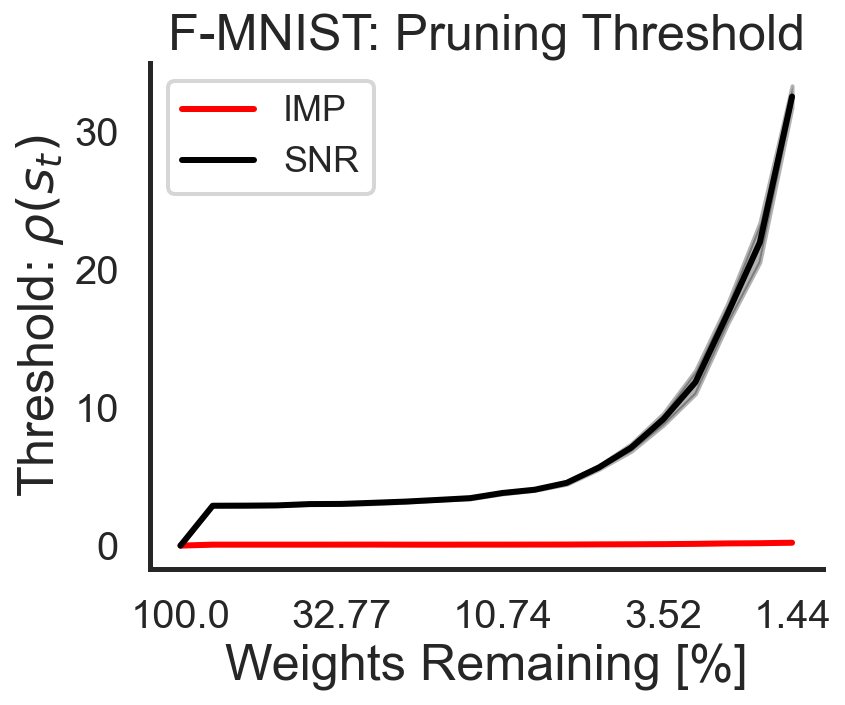

In [189]:
results = get_perf_env(meta_log, hyper_log, "prune_threshold", get_random=False)
fig, ax = plt.subplots(figsize=(6, 5))
imp_plot(results,
        fig=fig, ax=ax,
        num_imp_iters=20,
        plot_title=r"F-MNIST: Pruning Threshold",
        curve_labels=list(results.keys()),
        colors=["r", "black"],
        ylabel=r"Threshold: $\rho(s_t)$",
        plot_legend=True,
        plot_ylabel=True,
        plot_xlabel=True)

# Mean/Sigma/SNR over IMP Iterations

In [190]:
from mle_toolbox.utils import load_pkl_object

seed = 176588
base_dir = "../experiments/fmnist_snes_128/"
iter_00_lth = load_pkl_object(base_dir + f"b_1_eval_0/extra/seed_{seed}/imp_nets_1.pkl")
iter_10_lth = load_pkl_object(base_dir + f"b_1_eval_0/extra/seed_{seed}/imp_nets_10.pkl")
iter_15_lth = load_pkl_object(base_dir + f"b_1_eval_0/extra/seed_{seed}/imp_nets_15.pkl")
iter_20_lth = load_pkl_object(base_dir + f"b_1_eval_0/extra/seed_{seed}/imp_nets_20.pkl")

iter_00_s2n = load_pkl_object(base_dir + f"b_1_eval_2/extra/seed_{seed}/imp_nets_1.pkl")
iter_10_s2n = load_pkl_object(base_dir + f"b_1_eval_2/extra/seed_{seed}/imp_nets_10.pkl")
iter_15_s2n = load_pkl_object(base_dir + f"b_1_eval_2/extra/seed_{seed}/imp_nets_15.pkl")
iter_20_s2n = load_pkl_object(base_dir + f"b_1_eval_2/extra/seed_{seed}/imp_nets_20.pkl")

l = list(iter_00_lth["final_sigma"]["params"].keys())[1]

def get_weight_snr(iter_ckpt, layer_id):
    weights = np.abs(iter_ckpt["final_mean"]["params"][layer_id]["kernel"].reshape(-1))
    ids = weights != 0.0
    weights = weights[ids]
    sigma = iter_ckpt["final_sigma"]["params"][layer_id]["kernel"].reshape(-1)[ids]
    snr = weights/sigma
    return weights, sigma, snr

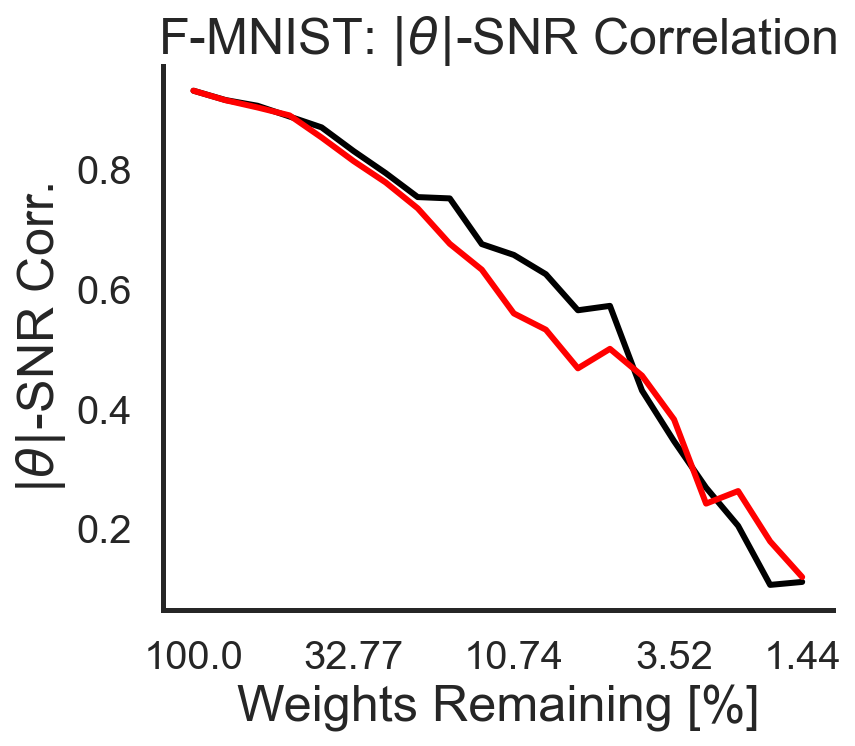

In [191]:
all_corr_s2n, all_corr_lth = [], []
for imp_iter in range(1, 21):
    corr = 0
    for seed in [176588, 363028, 381632, 562958, 924197]:
        iter_results = load_pkl_object(base_dir + f"b_1_eval_2/extra/seed_{seed}/imp_nets_{imp_iter}.pkl")
        weights, sigma, snr = get_weight_snr(iter_results, l)
        corr += stats.pearsonr(weights, snr)[0]
    all_corr_s2n.append(corr/5)
    
    corr = 0
    for seed in [176588, 363028, 381632, 562958, 924197]:
        iter_results = load_pkl_object(base_dir + f"b_1_eval_0/extra/seed_{seed}/imp_nets_{imp_iter}.pkl")
        weights, sigma, snr = get_weight_snr(iter_results, l)
        corr += stats.pearsonr(weights, snr)[0]
    all_corr_lth.append(corr/5)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(all_corr_s2n, c="black", label="SNR")
ax.plot(all_corr_lth, c="red", label="IMP")
# ax.legend()
ax.set_ylabel(r"$|\theta|$-SNR Corr.")
ax.set_xlabel("Weights Remaining [%]")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
num_iters = 20
xtick_labels = [
        round(sparse(i, 1 - 0.2), 2)
        for i in np.arange(0, num_iters, 5)
]
xtick_labels.append(round(sparse(num_iters - 1, 1 - 0.2), 2))
xticks = np.arange(0, num_iters, 5).tolist()
xticks.append(num_iters - 1)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set_title(r"F-MNIST: $|\theta|$-SNR Correlation")
ax.tick_params(axis="both", which="major", labelsize=20)

# Visualization for SNES Fetch Task

In [192]:
meta_log, hyper_log = load_result_logs("../experiments/fetch_snes_sigma")
hyper_log["imp_config/baseline_name"].unique()

/Users/rob/anaconda3/envs/mle-toolbox/lib/python3.9/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


array(['final-ticket', 'sig2noise'], dtype=object)

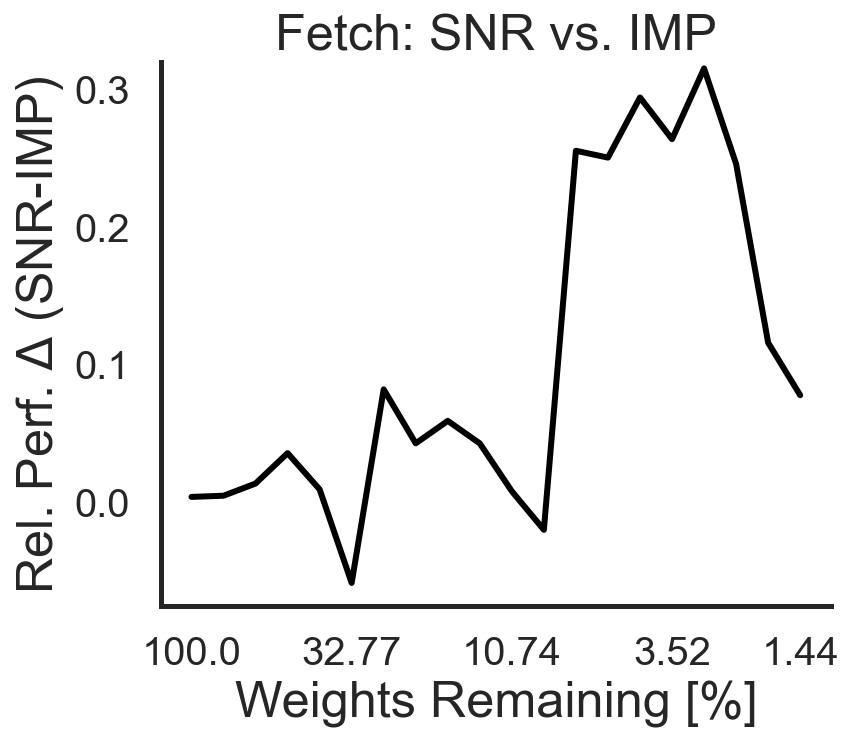

In [193]:
def get_perf_env(meta_log, hyper_log, metric="final_perf", get_random=True):
    """Filter dataframe for environment and popsize."""
    run_id_ticket = hyper_log.filter({"imp_config/baseline_name": "final-ticket"}).run_id.iloc[0]
    run_id_sig2noi = hyper_log.filter({"imp_config/baseline_name": "sig2noise"}).run_id.iloc[0]
    ticket_perf = meta_log[run_id_ticket].stats[metric]
    sig2noise_perf = meta_log[run_id_sig2noi].stats[metric]
    results = (sig2noise_perf.mean[:20] - ticket_perf.mean[:20])/sig2noise_perf.mean[0]
    return results

results = get_perf_env(meta_log, hyper_log, get_random=False)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(results, color="black")
ax.set_xlabel("Weights Remaining [%]")
ax.set_ylabel(r"Rel. Perf. $\Delta$ (SNR-IMP)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
num_iters = results.shape[0]
xtick_labels = [
        round(sparse(i, 1 - 0.2), 2)
        for i in np.arange(0, num_iters, 5)
]
xtick_labels.append(round(sparse(num_iters - 1, 1 - 0.2), 2))
xticks = np.arange(0, num_iters, 5).tolist()
xticks.append(num_iters - 1)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set_ylim(-0.075, 0.32)
ax.set_title("Fetch: SNR vs. IMP")
ax.tick_params(axis="both", which="major", labelsize=20)

In [157]:
def get_perf_env(meta_log, hyper_log, metric="final_perf", get_random=True):
    """Filter dataframe for environment and popsize."""
    run_id_ticket = hyper_log.filter({"imp_config/baseline_name": "final-ticket"}).run_id.iloc[0]
    run_id_sig2noi = hyper_log.filter({"imp_config/baseline_name": "sig2noise"}).run_id.iloc[0]
    ticket_perf = meta_log[run_id_ticket].stats[metric]
    sig2noise_perf = meta_log[run_id_sig2noi].stats[metric]
    results = {"IMP": ticket_perf, "SNR": sig2noise_perf}
    if get_random:
        run_id_random = hyper_log.filter({"imp_config/baseline_name": "random-reinit"}).run_id.iloc[0]
        random_perf = meta_log[run_id_random].stats[metric]
        results["random"] = random_perf
    return results

[100.0, 32.77, 10.74, 3.52, 1.44]


(<Figure size 432x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Fetch: Pruning Threshold'}, xlabel='Weights Remaining [%]', ylabel='Threshold: $\\rho(s_t)$'>)

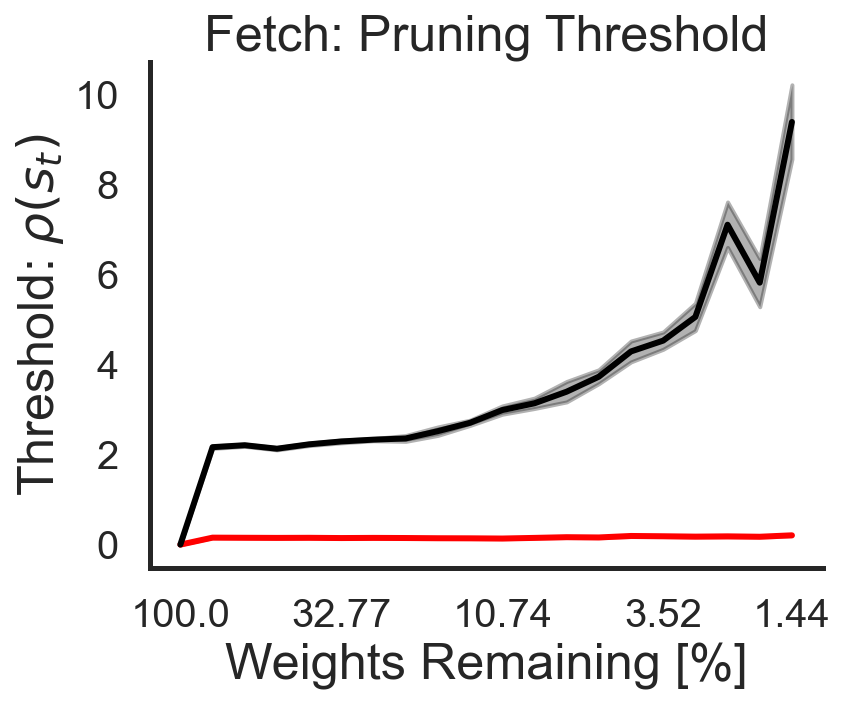

In [165]:
results = get_perf_env(meta_log, hyper_log, "prune_threshold", get_random=False)
fig, ax = plt.subplots(figsize=(6, 5))
imp_plot(results,
        fig=fig, ax=ax,
        num_imp_iters=20,
        plot_title=r"Fetch: Pruning Threshold",
        curve_labels=list(results.keys()),
        colors=["r", "black"],
        ylabel=r"Threshold: $\rho(s_t)$",
        plot_legend=False,
        plot_ylabel=True,
        plot_xlabel=True)

In [161]:
seed = 176588
iter_00_lth = load_pkl_object(f"../experiments/fetch_snes_sigma/b_1_eval_0/extra/seed_{seed}/imp_nets_1.pkl")
iter_10_lth = load_pkl_object(f"../experiments/fetch_snes_sigma/b_1_eval_0/extra/seed_{seed}/imp_nets_10.pkl")
iter_15_lth = load_pkl_object(f"../experiments/fetch_snes_sigma/b_1_eval_0/extra/seed_{seed}/imp_nets_15.pkl")
iter_20_lth = load_pkl_object(f"../experiments/fetch_snes_sigma/b_1_eval_0/extra/seed_{seed}/imp_nets_20.pkl")

iter_00_s2n = load_pkl_object(f"../experiments/fetch_snes_sigma/b_1_eval_1/extra/seed_{seed}/imp_nets_1.pkl")
iter_10_s2n = load_pkl_object(f"../experiments/fetch_snes_sigma/b_1_eval_1/extra/seed_{seed}/imp_nets_10.pkl")
iter_15_s2n = load_pkl_object(f"../experiments/fetch_snes_sigma/b_1_eval_1/extra/seed_{seed}/imp_nets_15.pkl")
iter_20_s2n = load_pkl_object(f"../experiments/fetch_snes_sigma/b_1_eval_1/extra/seed_{seed}/imp_nets_20.pkl")

l = list(iter_00_lth["final_sigma"]["params"].keys())[1]

def get_weight_snr(iter_ckpt, layer_id):
    weights = np.abs(iter_ckpt["final_mean"]["params"][layer_id]["kernel"].reshape(-1))
    ids = weights != 0.0
    weights = weights[ids]
    sigma = iter_ckpt["final_sigma"]["params"][layer_id]["kernel"].reshape(-1)[ids]
    snr = weights/sigma
    return weights, sigma, snr

list(iter_00_lth["final_sigma"]["params"].keys())

['Dense_0', 'Dense_1', 'Dense_2']

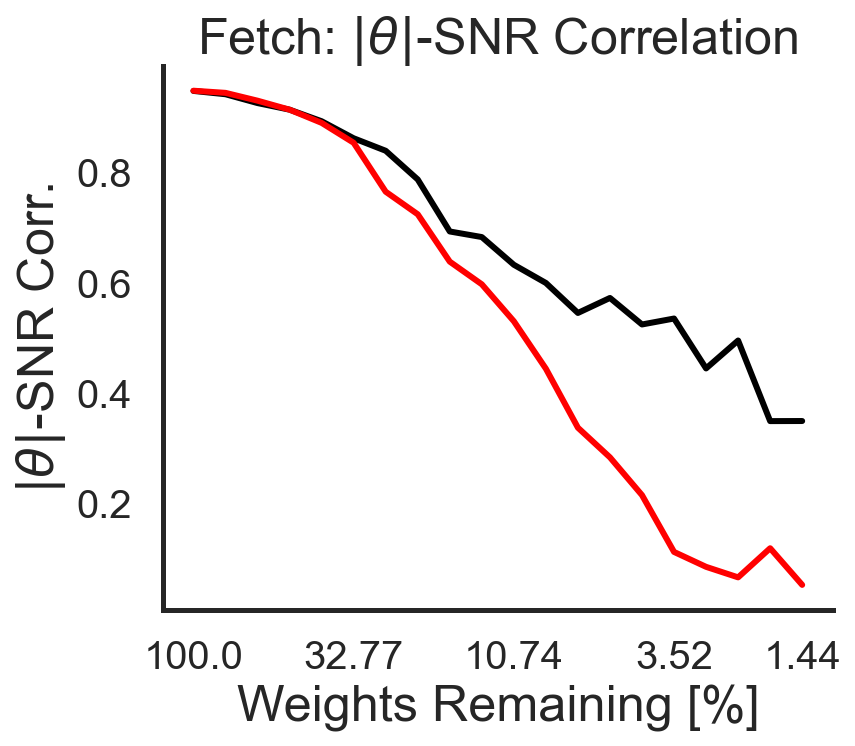

In [164]:
all_corr_s2n, all_corr_lth = [], []
for imp_iter in range(1, 21):
    corr = 0
    for seed in [176588, 363028, 381632, 562958, 924197]:
        iter_results = load_pkl_object(f"../experiments/fetch_snes_sigma/b_1_eval_1/extra/seed_{seed}/imp_nets_{imp_iter}.pkl")
        weights, sigma, snr = get_weight_snr(iter_results, l)
        corr += stats.pearsonr(weights, snr)[0]
    all_corr_s2n.append(corr/5)
    
    corr = 0
    for seed in [176588, 363028, 381632, 562958, 924197]:
        iter_results = load_pkl_object(f"../experiments/fetch_snes_sigma/b_1_eval_0/extra/seed_{seed}/imp_nets_{imp_iter}.pkl")
        weights, sigma, snr = get_weight_snr(iter_results, l)
        corr += stats.pearsonr(weights, snr)[0]
    all_corr_lth.append(corr/5)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(all_corr_s2n, c="black", label="SNR")
ax.plot(all_corr_lth, c="red", label="IMP")
# ax.legend()
ax.set_ylabel(r"$|\theta|$-SNR Corr.")
ax.set_xlabel("Weights Remaining [%]")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
num_iters = 20
xtick_labels = [
        round(sparse(i, 1 - 0.2), 2)
        for i in np.arange(0, num_iters, 5)
]
xtick_labels.append(round(sparse(num_iters - 1, 1 - 0.2), 2))
xticks = np.arange(0, num_iters, 5).tolist()
xticks.append(num_iters - 1)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set_title(r"Fetch: $|\theta|$-SNR Correlation")
ax.tick_params(axis="both", which="major", labelsize=20)

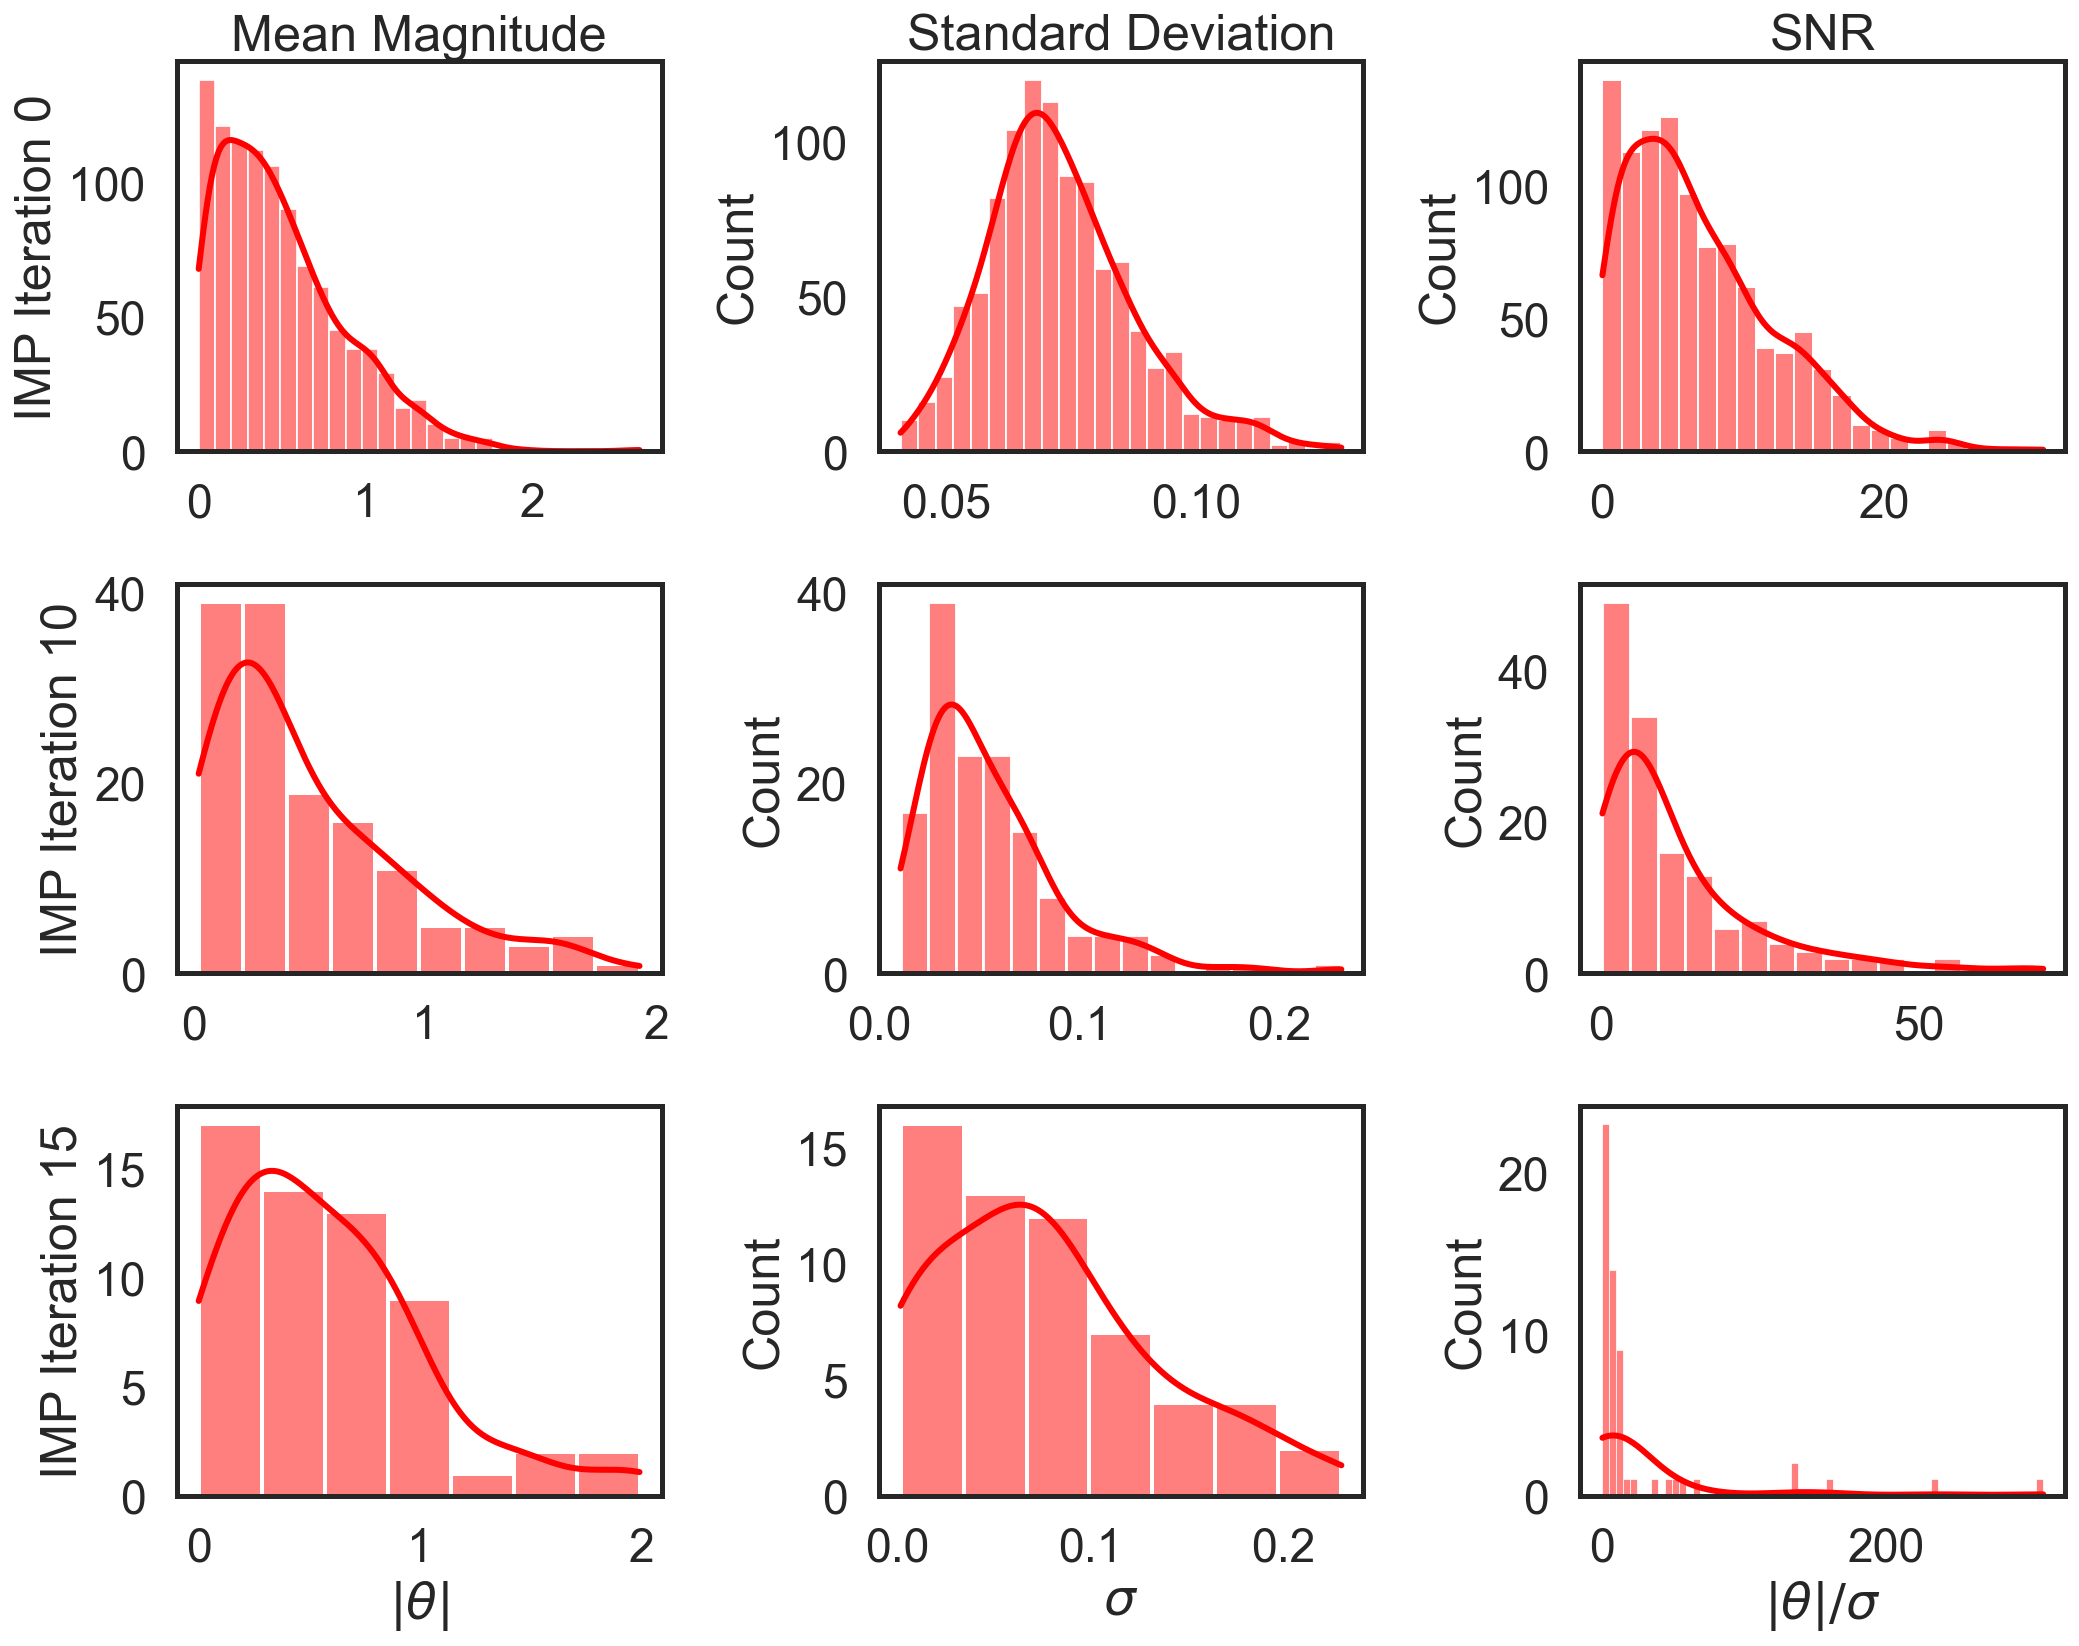

In [129]:
fig, axs = plt.subplots(3, 3, figsize=(15, 12))

weights, sigma, snr = get_weight_snr(iter_00_lth, l)
sns.histplot(weights, kde=True, ax=axs[0, 0], color="r")
sns.histplot(sigma, kde=True, ax=axs[0, 1], color="r")
sns.histplot(snr, kde=True, ax=axs[0, 2], color="r")

weights, sigma, snr = get_weight_snr(iter_10_lth, l)
sns.histplot(weights, kde=True, ax=axs[1, 0], color="r")
sns.histplot(sigma, kde=True, ax=axs[1, 1], color="r")
sns.histplot(snr, kde=True, ax=axs[1, 2], color="r")

weights, sigma, snr = get_weight_snr(iter_15_lth, l)
sns.histplot(weights, kde=True, ax=axs[2, 0], color="r")
sns.histplot(sigma, kde=True, ax=axs[2, 1], color="r")
sns.histplot(snr, kde=True, ax=axs[2, 2], color="r")

axs[0, 0].set_title("Mean Magnitude")
axs[0, 1].set_title("Standard Deviation")
axs[0, 2].set_title("SNR")
axs[2, 0].set_xlabel(r"$|\theta|$")
axs[2, 1].set_xlabel(r"$\sigma$")
axs[2, 2].set_xlabel(r"$|\theta|/\sigma$")

axs[0, 0].set_ylabel("IMP Iteration 0")
axs[1, 0].set_ylabel("IMP Iteration 10")
axs[2, 0].set_ylabel("IMP Iteration 15")
fig.tight_layout()


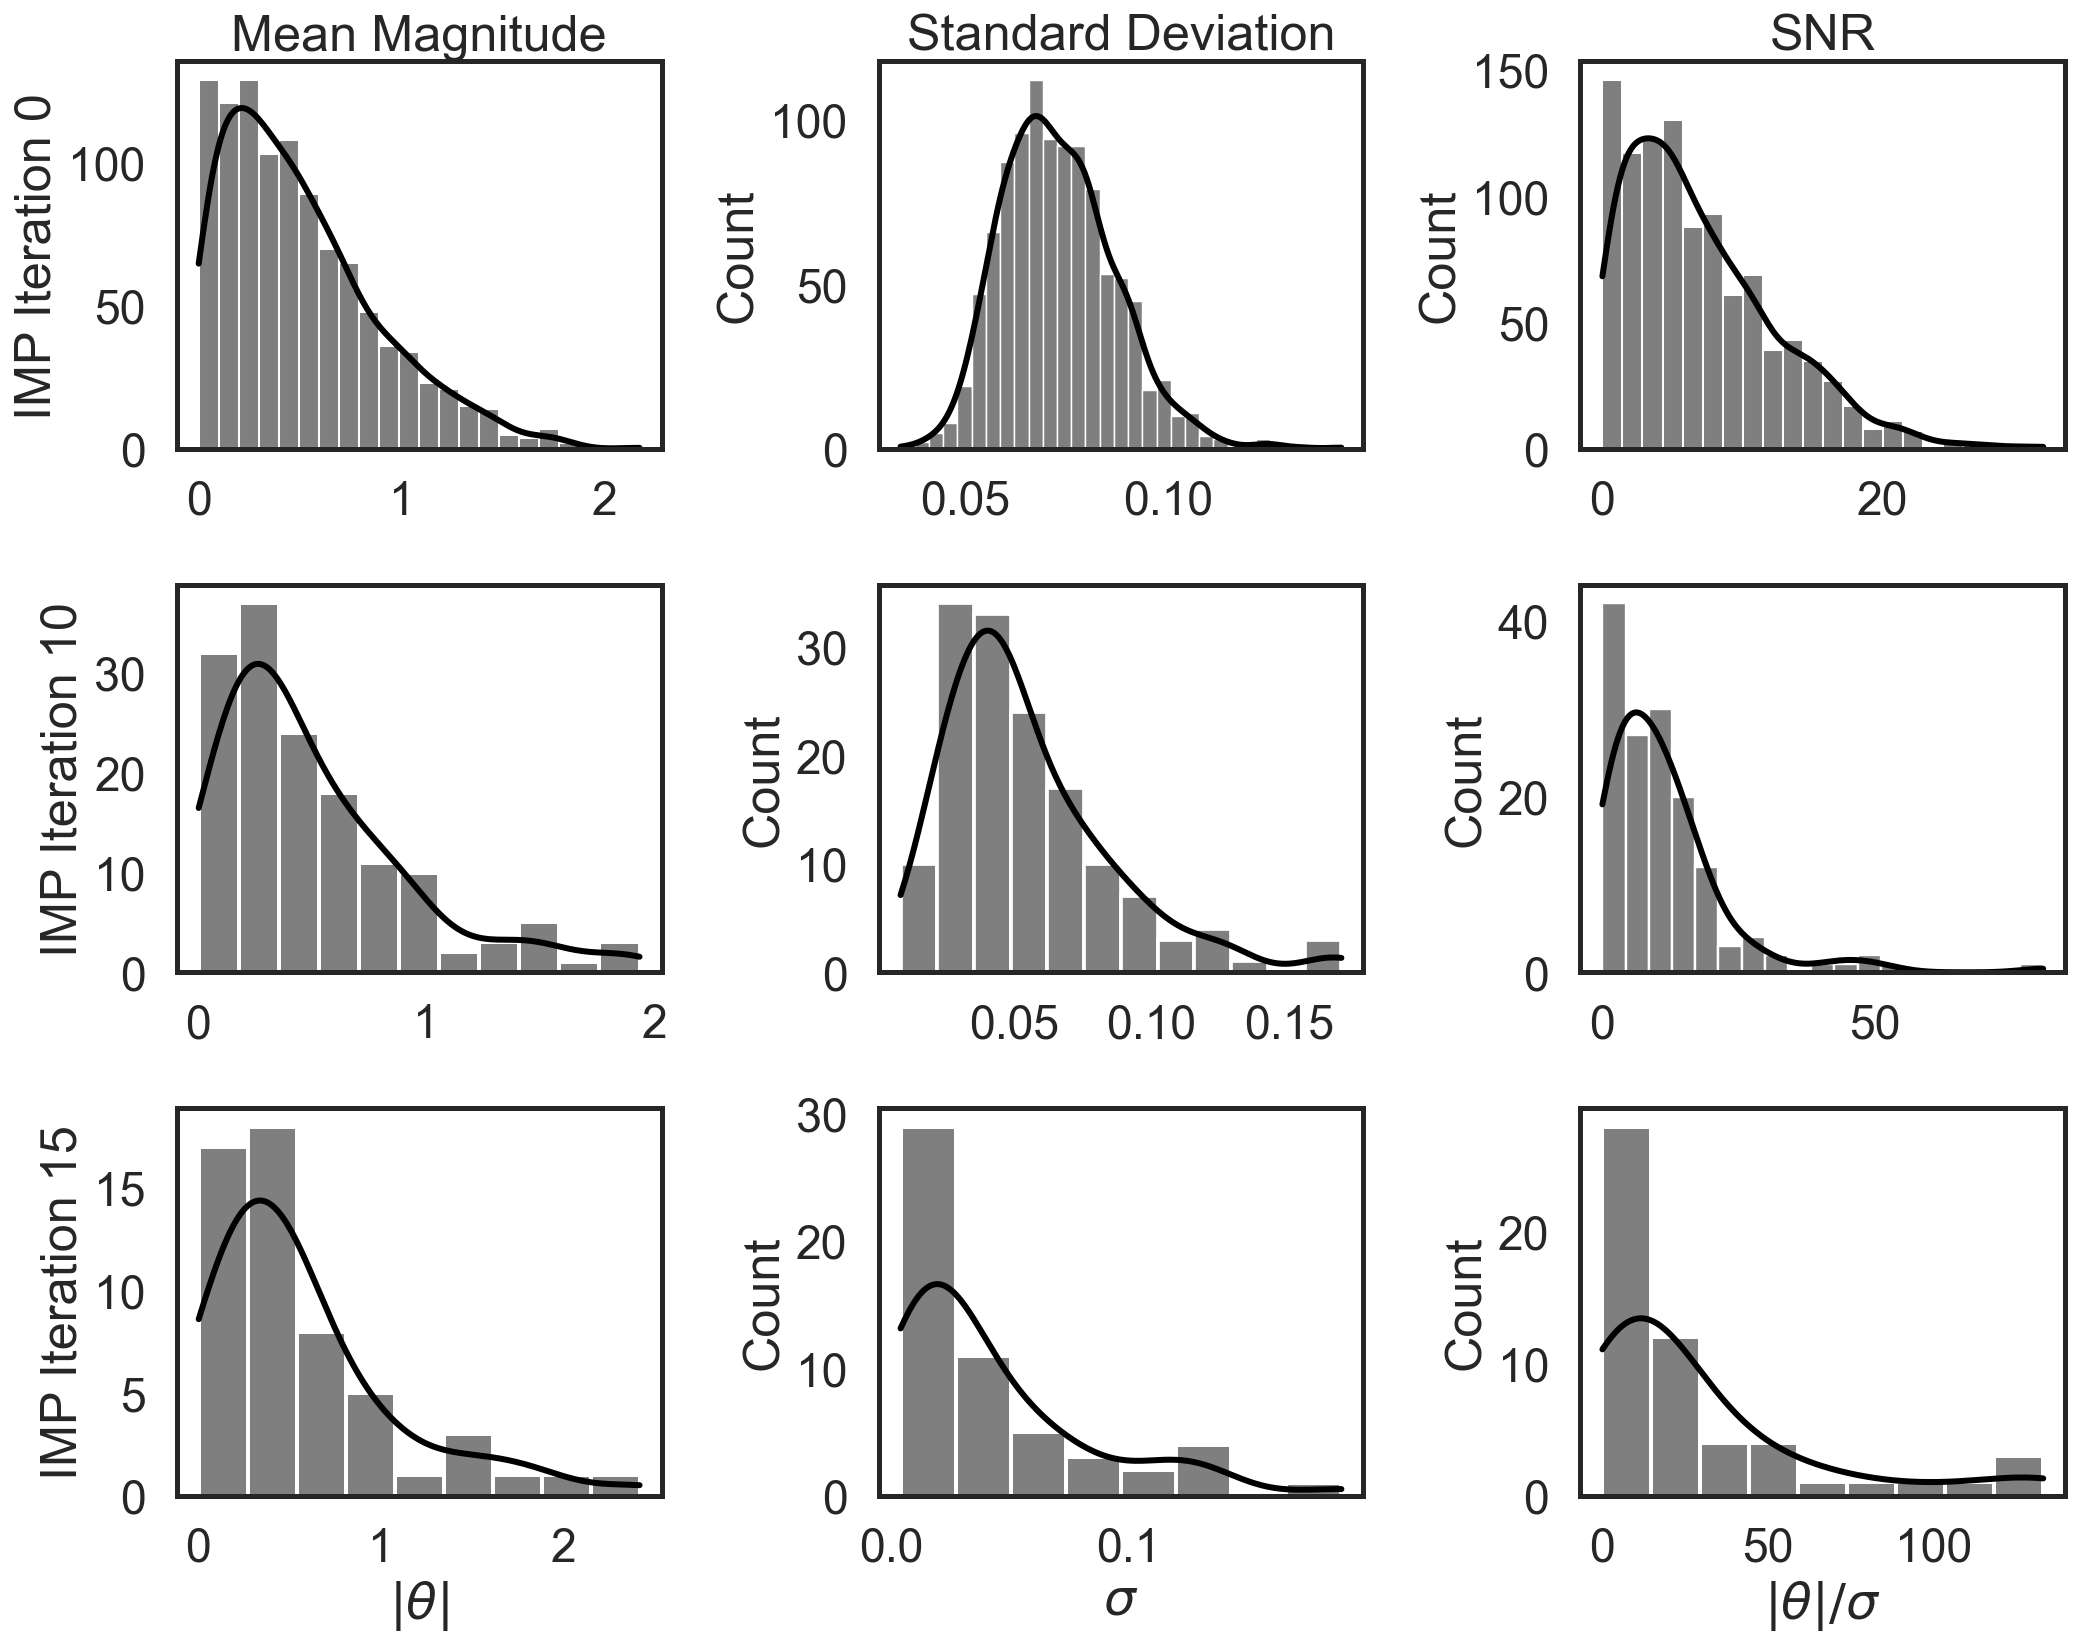

In [130]:
fig, axs = plt.subplots(3, 3, figsize=(15, 12))

weights, sigma, snr = get_weight_snr(iter_00_s2n, l)
sns.histplot(weights, kde=True, ax=axs[0, 0], color="black")
sns.histplot(sigma, kde=True, ax=axs[0, 1], color="black")
sns.histplot(snr, kde=True, ax=axs[0, 2], color="black")

weights, sigma, snr = get_weight_snr(iter_10_s2n, l)
sns.histplot(weights, kde=True, ax=axs[1, 0], color="black")
sns.histplot(sigma, kde=True, ax=axs[1, 1], color="black")
sns.histplot(snr, kde=True, ax=axs[1, 2], color="black")

weights, sigma, snr = get_weight_snr(iter_15_s2n, l)
sns.histplot(weights, kde=True, ax=axs[2, 0], color="black")
sns.histplot(sigma, kde=True, ax=axs[2, 1], color="black")
sns.histplot(snr, kde=True, ax=axs[2, 2], color="black")

axs[0, 0].set_title("Mean Magnitude")
axs[0, 1].set_title("Standard Deviation")
axs[0, 2].set_title("SNR")
axs[2, 0].set_xlabel(r"$|\theta|$")
axs[2, 1].set_xlabel(r"$\sigma$")
axs[2, 2].set_xlabel(r"$|\theta|/\sigma$")

axs[0, 0].set_ylabel("IMP Iteration 0")
axs[1, 0].set_ylabel("IMP Iteration 10")
axs[2, 0].set_ylabel("IMP Iteration 15")
fig.tight_layout()


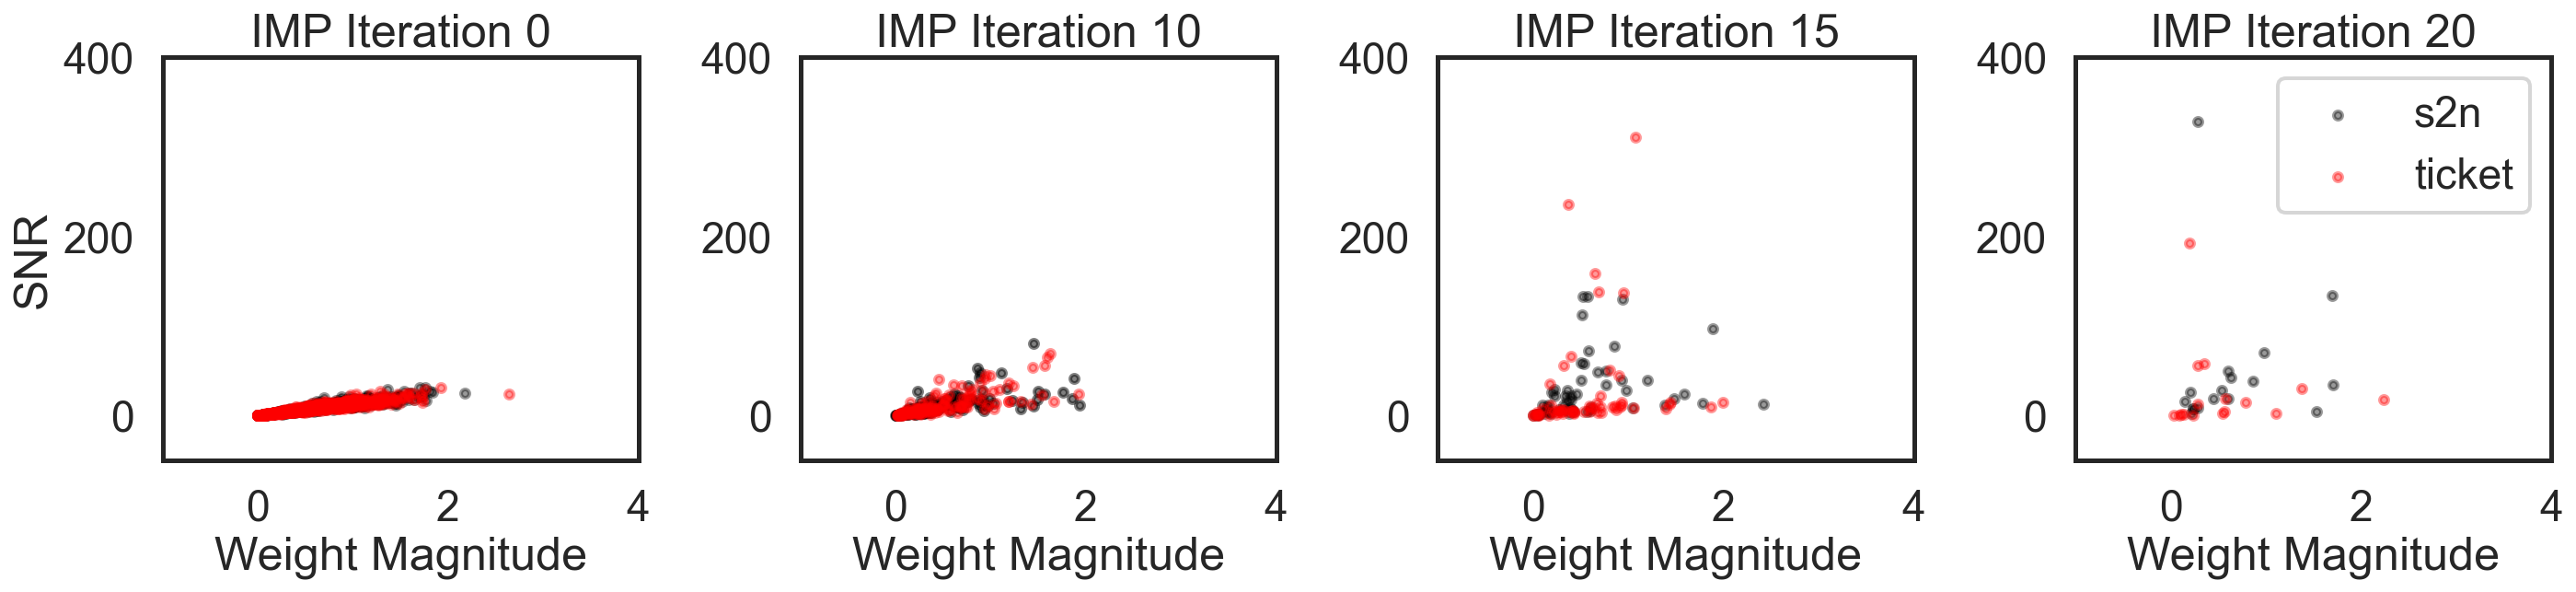

In [131]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

alpha = 0.4
weights, sigma, snr = get_weight_snr(iter_00_s2n, l)
axs[0].scatter(weights, snr, s=20, c="black", alpha=alpha)
weights, sigma, snr = get_weight_snr(iter_00_lth, l)
axs[0].scatter(weights, snr, s=20, c="red", alpha=alpha)

weights, sigma, snr = get_weight_snr(iter_10_s2n, l)
axs[1].scatter(weights, snr, s=20, c="black", alpha=0.5)
weights, sigma, snr = get_weight_snr(iter_10_lth, l)
axs[1].scatter(weights, snr, s=20, c="red", alpha=alpha)

weights, sigma, snr = get_weight_snr(iter_15_s2n, l)
axs[2].scatter(weights, snr, s=20, c="black", alpha=alpha)
weights, sigma, snr = get_weight_snr(iter_15_lth, l)
axs[2].scatter(weights, snr, s=20, c="red", alpha=alpha)

weights, sigma, snr = get_weight_snr(iter_20_s2n, l)
axs[3].scatter(weights, snr, s=20, c="black", alpha=alpha, label="s2n")
weights, sigma, snr = get_weight_snr(iter_20_lth, l)
axs[3].scatter(weights, snr, s=20, c="red", alpha=alpha, label="ticket")

for i in range(4):
    axs[i].set_ylim(-50, 400)
    axs[i].set_xlim(-1, 4)
    axs[i].set_xlabel("Weight Magnitude")
    if i == 0:
        axs[i].set_ylabel("SNR")

axs[0].set_title("IMP Iteration 0")
axs[1].set_title("IMP Iteration 10")
axs[2].set_title("IMP Iteration 15")
axs[3].set_title("IMP Iteration 20")
axs[3].legend()
fig.tight_layout()

Text(0.5, 0, 'IMP Iteration')

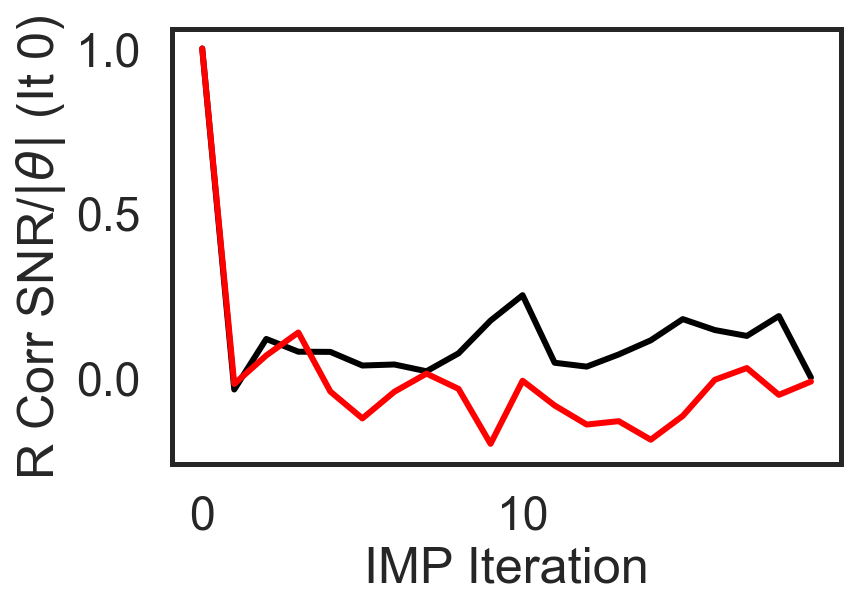

In [133]:
# Filter weights by last IMP iteration
def get_weight_snr_filter(iter_ckpt, layer_id, weight_ids):
    weights = np.abs(iter_ckpt["final_mean"]["params"][layer_id]["kernel"].reshape(-1))
    weights = weights[weight_ids]
    sigma = iter_ckpt["final_sigma"]["params"][layer_id]["kernel"].reshape(-1)[weight_ids]
    snr = weights/sigma
    return weights, sigma, snr

all_results = []
for seed in [176588, 363028, 381632, 562958, 924197]:
    # Get weights which were not pruned in final IMP iteration
    iter_final = load_pkl_object(f"../experiments/fetch_snes_sigma/b_1_eval_1/extra/seed_{seed}/imp_nets_20.pkl")
    weights = iter_final["final_mean"]["params"][l]["kernel"].reshape(-1)
    weight_ids = weights != 0.0

    iter_results = load_pkl_object(f"../experiments/fetch_snes_sigma/b_1_eval_1/extra/seed_{seed}/imp_nets_1.pkl")
    _, _, snr_0 = get_weight_snr_filter(iter_results, l, weight_ids)

    all_corr_s2n, all_corr_lth = [], []
    for imp_iter in range(1, 21):
        corr = 0
        iter_results = load_pkl_object(f"../experiments/fetch_snes_sigma/b_1_eval_1/extra/seed_{seed}/imp_nets_{imp_iter}.pkl")
        weights, sigma, snr = get_weight_snr_filter(iter_results, l, weight_ids)
        
        iter_results = load_pkl_object(f"../experiments/fetch_snes_sigma/b_1_eval_1/extra/seed_{seed}/imp_nets_{imp_iter}.pkl")
        weights, sigma, snr = get_weight_snr_filter(iter_results, l, weight_ids)
        corr += stats.spearmanr(snr_0, snr).correlation
        all_corr_s2n.append(corr)
    all_results.append(all_corr_s2n)

mean_corr = np.stack(all_results).mean(axis=0)

fig, axs = plt.subplots()
axs.plot(mean_corr, c="black", label="s2n")

all_results = []
for seed in [176588, 363028, 381632, 562958, 924197]:
    # Get weights which were not pruned in final IMP iteration
    iter_final = load_pkl_object(f"../experiments/fetch_snes_sigma/b_1_eval_0/extra/seed_{seed}/imp_nets_20.pkl")
    weights = iter_final["final_mean"]["params"][l]["kernel"].reshape(-1)
    weight_ids = weights != 0.0

    iter_results = load_pkl_object(f"../experiments/fetch_snes_sigma/b_1_eval_0/extra/seed_{seed}/imp_nets_1.pkl")
    weights_0, _, _ = get_weight_snr_filter(iter_results, l, weight_ids)

    all_corr_s2n, all_corr_lth = [], []
    for imp_iter in range(1, 21):
        corr = 0
        iter_results = load_pkl_object(f"../experiments/fetch_snes_sigma/b_1_eval_0/extra/seed_{seed}/imp_nets_{imp_iter}.pkl")
        weights, sigma, snr = get_weight_snr_filter(iter_results, l, weight_ids)
        corr += stats.spearmanr(weights_0, weights).correlation
        all_corr_s2n.append(corr)
    all_results.append(all_corr_s2n)

mean_corr = np.stack(all_results).mean(axis=0)
axs.plot(mean_corr, c="red", label="ticket")
axs.set_ylabel(r"R Corr SNR/$|\theta|$ (It 0)")
axs.set_xlabel("IMP Iteration")